# Deep Learning Class Assigment


# 1. Data preparation


In [1]:
# 코드가 너무 길어서 주석으로 설명 달지 않고  ppt 파일에 정리했습니다! 

!pip install split-folders seaborn tqdm 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d lantian773030/pokemonclassification

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          29698        822  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           2851         78  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           5213        107  1.0              
mohithsairamreddy/salary-data 

In [4]:
!unzip pokemonclassification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: PokemonData/Golbat/78bb8cd2828f40158fc0dcd4c0366a57.jpg  
  inflating: PokemonData/Golbat/7b7a064d3a1b4c53a9be936d4e4e3bab.jpg  
  inflating: PokemonData/Golbat/7d07fd6776fb40e9986a1a0f62233325.jpg  
  inflating: PokemonData/Golbat/815b279060b94e12a6b35d434a5250c2.jpg  
  inflating: PokemonData/Golbat/818014085ff04885b31eb5e8737012f2.jpg  
  inflating: PokemonData/Golbat/87529331a47b4a5cb5d10a6b3ea46d84.jpg  
  inflating: PokemonData/Golbat/914fab74d32e49a98940d5ba7f674fa6.jpg  
  inflating: PokemonData/Golbat/949a05bd0ad44be993e5fd89a8f582df.jpg  
  inflating: PokemonData/Golbat/9a4c793b9b0042a99ebd540897f9f898.jpg  
  inflating: PokemonData/Golbat/a35b4e8e603c485cb197520af30e1208.jpg  
  inflating: PokemonData/Golbat/a45a14a67a7348bba57c06467bb73cde.jpg  
  inflating: PokemonData/Golbat/acc2b44eada74a25a64c041b2e80c453.jpg  
  inflating: PokemonData/Golbat/af30483e382240d38890dec39e083b08.jpg  
  inflating: PokemonData/Golbat/b45112786

In [5]:
# this should show your assignemnt root directory
import os
os.getcwd()

'/content'

In [6]:
# this is for spliting data
import splitfolders

image_dir = './PokemonData'
splitfolders.ratio(image_dir, output="input", seed=1337, ratio=(.7, .1, .2), group_prefix=None, move=False) # default values
cmd="splitfolders.ratio('" + image_dir + "', output='output', seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)"
cmd = '%s' % cmd
print(cmd)

Copying files: 6837 files [00:02, 2514.51 files/s]

splitfolders.ratio('./PokemonData', output='output', seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)


# 2. Programming Starts here

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# checking gpu
!nvidia-smi

Mon Jun 12 06:40:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
from PIL import Image
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import time

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Total number of categories: 150
Total number of images in training dataset: 4716


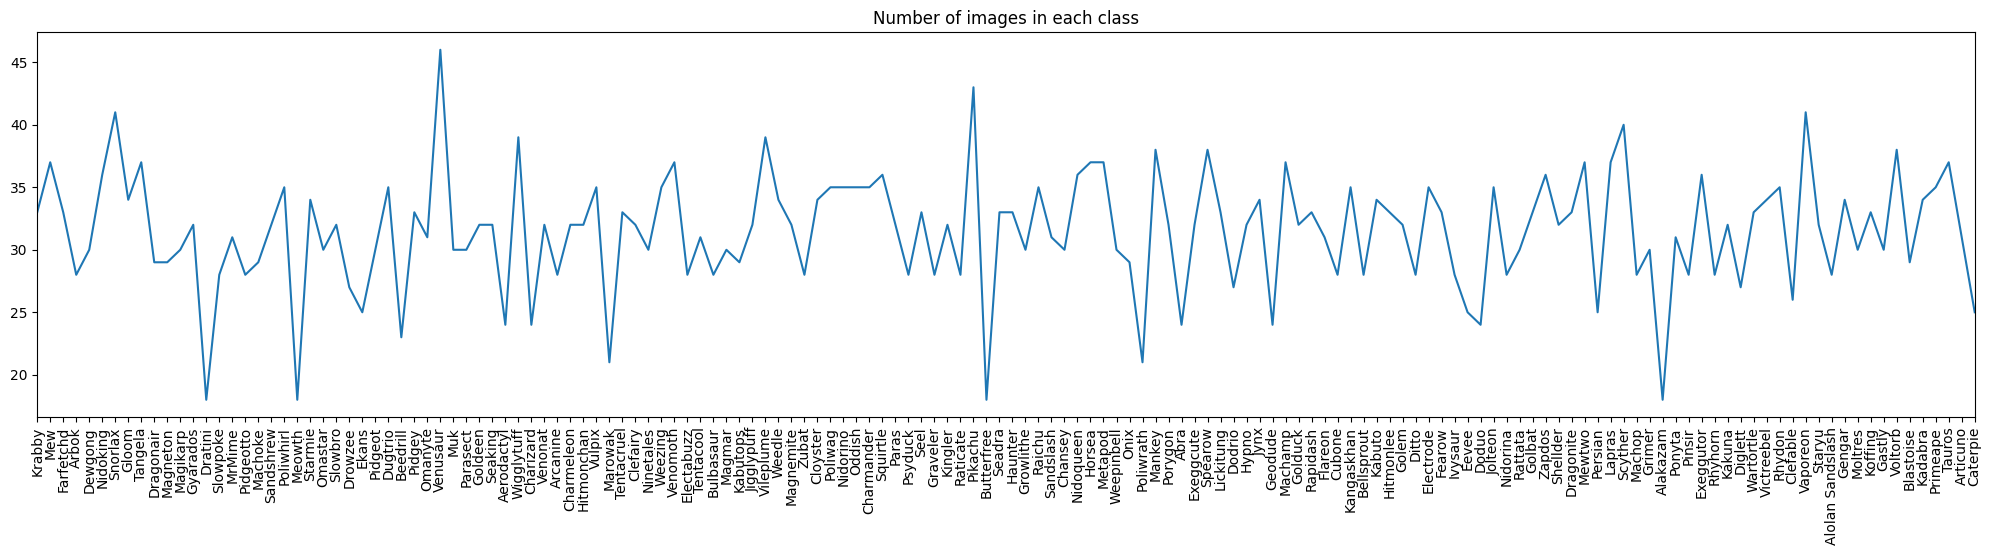

In [10]:
#Check image folder structure
#print(os.listdir(image_dir)[:10])

#Let's check the dataset for each classes

import seaborn as sns

data_dir= './input'
train_dir=data_dir+'/train'
classes = os.listdir(train_dir) # List of all classes
print(f'Total number of categories: {len(classes)}')


counts = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(train_dir, c)))
print(f'Total number of images in training dataset: {sum(list(counts.values()))}')
# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [11]:
# constants
batch_size = 4
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

#torch.manual_seed(42)
epochs = 1 # you better change this. 1 is just for my testing

In [12]:
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

In [13]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform = train_transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform = test_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform = test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes
num_classes=len(class_names)

print(f'Num classes: {num_classes}')
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

Num classes: 150
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk'

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


In [15]:
stats = [[0.485,0.456,0.406],[0.229,0.224,0.225]]

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

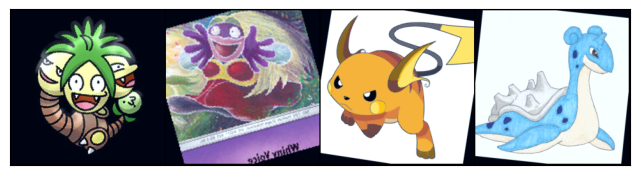

In [ ]:
show_batch(train_loader)

In [16]:
# model_0
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu(self.conv1(X)) # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)) # conv2
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) # conv3
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
#torch.manual_seed(101)
model = ConvolutionalNetwork()
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
)

### Training

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
def train(model, epochs, train_loader, val_loader=None):
  model.train()
  start_time = time.time()

  # Trackers
  train_losses = []
  val_losses = []
  train_correct = []
  val_correct = []

  for i in range(epochs):
      trn_corr = 0
      val_corr=0
      tst_corr = 0
      train_loss=0
      
      # Training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b += 1
          
          X_train = X_train.to(device)
          y_train = y_train.to(device)
          
          y_pred = model(X_train)
          loss = criterion(y_pred, y_train)
          train_loss += loss.item()
          # Tracking correct predictions
          _, preds = torch.max(y_pred, dim=1)
          #batch_corr=torch.sum(preds == y_train).item() / len(preds)
          batch_corr = torch.sum(preds == y_train)
          trn_corr += batch_corr
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # Print epoch and loss results
          if b%100==0:
              print(f'EPOCH: {i}  LOSS: {loss.item():10.8f}')
          
      train_losses.append(train_loss)
      train_correct.append(trn_corr)
     
      # Testing batches
      loss=0
      if val_loader:
          with torch.no_grad():
              for b, (X_val, y_val) in enumerate(val_loader):
                  
                  X_val = X_val.to(device)
                  y_val = y_val.to(device)

                  y_pred = model(X_val)

                  # Tracking correct predictions
                  predicted = torch.max(y_pred.data, 1)[1] 
                  val_corr += (predicted == y_val).sum()
                  loss += criterion(y_pred, y_val)
          print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')         
          #loss = criterion(y_pred, y_val)
          val_losses.append(loss)
          val_correct.append(val_corr)
          print(
              f"EPOCH: {epochs} - VAL LOSS: {loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item() / len(val_loader.dataset):.4f}"
          )
          
  print(f'\nDuration: {((time.time() - start_time)/60):.3f} minutes') 

In [33]:
model = ConvolutionalNetwork()
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, 10, train_loader, val_loader)
torch.save(model.state_dict(), 'PokemonModel.pt')   # save the trained model. you can load the trained model later when necessary

EPOCH: 0  LOSS: 5.05133772
EPOCH: 0  LOSS: 4.94758034
EPOCH: 0  LOSS: 4.97513580
EPOCH: 0  LOSS: 4.97771263
EPOCH: 0  LOSS: 4.76709509
EPOCH: 0  LOSS: 4.21352816
EPOCH: 0  LOSS: 4.64680052
EPOCH: 0  LOSS: 4.03113842
EPOCH: 0  LOSS: 6.10755539
EPOCH: 0  LOSS: 3.36868620
EPOCH: 0  LOSS: 4.47727156

Validation Accuracy: 0.04552845528455285 minutes
EPOCH: 10 - VAL LOSS: 1.0400, VAL_ACCURACY: 0.0455
EPOCH: 1  LOSS: 3.60198665
EPOCH: 1  LOSS: 4.21041870
EPOCH: 1  LOSS: 3.82004881
EPOCH: 1  LOSS: 3.69846058
EPOCH: 1  LOSS: 3.03212023
EPOCH: 1  LOSS: 2.64604330
EPOCH: 1  LOSS: 2.96808720
EPOCH: 1  LOSS: 4.06741476
EPOCH: 1  LOSS: 2.61039495
EPOCH: 1  LOSS: 3.51944017
EPOCH: 1  LOSS: 4.07917356

Validation Accuracy: 0.14308943089430895 minutes
EPOCH: 10 - VAL LOSS: 0.8789, VAL_ACCURACY: 0.1431
EPOCH: 2  LOSS: 3.68236279
EPOCH: 2  LOSS: 3.62957144
EPOCH: 2  LOSS: 3.80496025
EPOCH: 2  LOSS: 2.15801573
EPOCH: 2  LOSS: 4.39748764
EPOCH: 2  LOSS: 2.89772344
EPOCH: 2  LOSS: 3.17725635
EPOCH: 2  LOSS:

In [19]:
def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            correct += (labels == predicted).sum()
    test_acc=(correct.item()/len(data_loader.dataset))*100
    print(
        f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item() / len(data_loader.dataset):.4f}"
    )

In [42]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("PokemonModel.pt"))
model.to(device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
)

In [43]:
#model.load_state_dict(torch.load('PokemonModel.pt'))
test(model, test_loader)

TEST LOSS: 0.6417, accuracy: 0.4055


# 3. Assignment

## 1. Several Techniques (2pts)


In [ ]:
# your code for Xavier weight initialization
class ConvolutionalNetwork_Xavier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.xavier_init()

    def forward(self, X):
        X = F.relu(self.conv1(X)) # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)) # conv2
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) # conv3
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

    def xavier_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

In [ ]:
model = ConvolutionalNetwork_Xavier()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_xavier.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 4.99794483
EPOCH: 0  LOSS: 5.00485229
EPOCH: 0  LOSS: 5.03981495
EPOCH: 0  LOSS: 4.96498871
EPOCH: 0  LOSS: 4.72630692
EPOCH: 0  LOSS: 4.77327728
EPOCH: 0  LOSS: 5.08466101
EPOCH: 0  LOSS: 4.30851078
EPOCH: 0  LOSS: 4.96676826
EPOCH: 0  LOSS: 4.01451540
EPOCH: 0  LOSS: 4.34037971

Validation Accuracy: 0.04552845528455285 minutes
EPOCH: 10 - VAL LOSS: 1.0944, VAL_ACCURACY: 0.0455
EPOCH: 1  LOSS: 2.91078520
EPOCH: 1  LOSS: 4.39623499
EPOCH: 1  LOSS: 4.86565399
EPOCH: 1  LOSS: 4.45246124
EPOCH: 1  LOSS: 3.98074007
EPOCH: 1  LOSS: 3.95242119
EPOCH: 1  LOSS: 4.15705347
EPOCH: 1  LOSS: 3.88272190
EPOCH: 1  LOSS: 2.97625351
EPOCH: 1  LOSS: 3.02164650
EPOCH: 1  LOSS: 5.04175234

Validation Accuracy: 0.1008130081300813 minutes
EPOCH: 10 - VAL LOSS: 0.9805, VAL_ACCURACY: 0.1008
EPOCH: 2  LOSS: 3.39601374
EPOCH: 2  LOSS: 2.85079074
EPOCH: 2  LOSS: 2.93538523
EPOCH: 2  LOSS: 5.27198744
EPOCH: 2  LOSS: 3.69243002
EPOCH: 2  LOSS: 2.83367395
EPOCH: 2  LOSS: 4.27473879
EPOCH: 2  LOSS: 

In [ ]:
# your code for L2 regularization, same with model-0
class ConvolutionalNetwork_L2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu(self.conv1(X)) # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)) # conv2
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) # conv3
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
                  

In [ ]:
model = ConvolutionalNetwork_L2()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

train(model, 10, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_L2.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 4.93575668
EPOCH: 0  LOSS: 4.97785807
EPOCH: 0  LOSS: 4.89169884
EPOCH: 0  LOSS: 4.99137640
EPOCH: 0  LOSS: 4.68660259
EPOCH: 0  LOSS: 4.48804426
EPOCH: 0  LOSS: 4.92843199
EPOCH: 0  LOSS: 5.35685968
EPOCH: 0  LOSS: 4.54351711
EPOCH: 0  LOSS: 4.68299437
EPOCH: 0  LOSS: 4.56104088

Validation Accuracy: 0.022764227642276424 minutes
EPOCH: 10 - VAL LOSS: 1.1485, VAL_ACCURACY: 0.0228
EPOCH: 1  LOSS: 4.31554556
EPOCH: 1  LOSS: 4.24742079
EPOCH: 1  LOSS: 4.57547617
EPOCH: 1  LOSS: 4.02843857
EPOCH: 1  LOSS: 5.26788139
EPOCH: 1  LOSS: 4.66491699
EPOCH: 1  LOSS: 5.12666607
EPOCH: 1  LOSS: 4.17567158
EPOCH: 1  LOSS: 4.82530975
EPOCH: 1  LOSS: 4.90347862
EPOCH: 1  LOSS: 3.98525739

Validation Accuracy: 0.032520325203252036 minutes
EPOCH: 10 - VAL LOSS: 1.1044, VAL_ACCURACY: 0.0325
EPOCH: 2  LOSS: 2.91186476
EPOCH: 2  LOSS: 3.78874969
EPOCH: 2  LOSS: 3.33074284
EPOCH: 2  LOSS: 4.12609577
EPOCH: 2  LOSS: 4.22102261
EPOCH: 2  LOSS: 4.81868982
EPOCH: 2  LOSS: 4.63804817
EPOCH: 2  LOS

In [ ]:
# your code for Dropout
class ConvolutionalNetwork_drop2(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.2)
  
    def forward(self, X):
        X = F.relu(self.conv1(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))

        # dropout
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)
  

In [ ]:
model = ConvolutionalNetwork_drop2()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_drop.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 5.08774853
EPOCH: 0  LOSS: 4.97669363
EPOCH: 0  LOSS: 5.00717735
EPOCH: 0  LOSS: 5.05939198
EPOCH: 0  LOSS: 5.25726986
EPOCH: 0  LOSS: 4.68987513
EPOCH: 0  LOSS: 5.02485418
EPOCH: 0  LOSS: 4.84030151
EPOCH: 0  LOSS: 4.51989269
EPOCH: 0  LOSS: 4.10639191
EPOCH: 0  LOSS: 4.40461588

Validation Accuracy: 0.022764227642276424 minutes
EPOCH: 10 - VAL LOSS: 1.1313, VAL_ACCURACY: 0.0228
EPOCH: 1  LOSS: 3.88542652
EPOCH: 1  LOSS: 4.17271900
EPOCH: 1  LOSS: 4.43292522
EPOCH: 1  LOSS: 4.32865143
EPOCH: 1  LOSS: 4.63483667
EPOCH: 1  LOSS: 4.09873962
EPOCH: 1  LOSS: 4.63442802
EPOCH: 1  LOSS: 3.50533199
EPOCH: 1  LOSS: 3.97844315
EPOCH: 1  LOSS: 4.36902475
EPOCH: 1  LOSS: 3.70185280

Validation Accuracy: 0.04227642276422764 minutes
EPOCH: 10 - VAL LOSS: 1.0784, VAL_ACCURACY: 0.0423
EPOCH: 2  LOSS: 3.97712278
EPOCH: 2  LOSS: 5.01504469
EPOCH: 2  LOSS: 3.36151981
EPOCH: 2  LOSS: 3.85268307
EPOCH: 2  LOSS: 3.77659988
EPOCH: 2  LOSS: 4.79510784
EPOCH: 2  LOSS: 3.63562369
EPOCH: 2  LOSS

In [31]:
# your code for Dropout
class ConvolutionalNetwork_drop5(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        # dropout layer
        self.dropout = nn.Dropout(p=0.5)
  
    def forward(self, X):
        X = F.relu(self.conv1(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))

        # dropout
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [32]:
model = ConvolutionalNetwork_drop5()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_drop.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 5.01799583
EPOCH: 0  LOSS: 5.13121319
EPOCH: 0  LOSS: 5.05074692
EPOCH: 0  LOSS: 5.01747322
EPOCH: 0  LOSS: 5.01946545
EPOCH: 0  LOSS: 4.76717854
EPOCH: 0  LOSS: 4.97355270
EPOCH: 0  LOSS: 5.05326271
EPOCH: 0  LOSS: 4.84281492
EPOCH: 0  LOSS: 5.02712440
EPOCH: 0  LOSS: 4.93198681

Validation Accuracy: 0.024390243902439025 minutes
EPOCH: 10 - VAL LOSS: 1.1940, VAL_ACCURACY: 0.0244
EPOCH: 1  LOSS: 4.74142981
EPOCH: 1  LOSS: 4.25047922
EPOCH: 1  LOSS: 4.48540878
EPOCH: 1  LOSS: 4.45523882
EPOCH: 1  LOSS: 4.28610992
EPOCH: 1  LOSS: 4.24260902
EPOCH: 1  LOSS: 4.89708996
EPOCH: 1  LOSS: 4.61911869
EPOCH: 1  LOSS: 4.89679766
EPOCH: 1  LOSS: 4.83476639
EPOCH: 1  LOSS: 4.92377615

Validation Accuracy: 0.032520325203252036 minutes
EPOCH: 10 - VAL LOSS: 1.1372, VAL_ACCURACY: 0.0325
EPOCH: 2  LOSS: 4.87416887
EPOCH: 2  LOSS: 4.28172064
EPOCH: 2  LOSS: 4.04501390
EPOCH: 2  LOSS: 4.37685394
EPOCH: 2  LOSS: 4.76938820
EPOCH: 2  LOSS: 4.29551506
EPOCH: 2  LOSS: 4.44921970
EPOCH: 2  LOS

In [20]:
# your code for Batch Normalization

class ConvolutionalNetwork_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1, bias=False)

        # Batch norm 적용
        self.batchnorm = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu((self.conv1(X))) # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu((self.conv2(X))) # conv2
        X = F.max_pool2d(X, 2, 2)

        # Batch norm 적용
        X = F.relu(self.batchnorm(self.conv3(X))) # conv3
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu((self.fc1(X)))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)
    

In [ ]:
model = ConvolutionalNetwork_bn()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_bn.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 4.70772457
EPOCH: 0  LOSS: 5.10430717
EPOCH: 0  LOSS: 5.14066696
EPOCH: 0  LOSS: 4.96490097
EPOCH: 0  LOSS: 4.85310793
EPOCH: 0  LOSS: 5.02217197
EPOCH: 0  LOSS: 5.12767982
EPOCH: 0  LOSS: 5.04647398
EPOCH: 0  LOSS: 4.99645805
EPOCH: 0  LOSS: 4.99651051
EPOCH: 0  LOSS: 4.98566818

Validation Accuracy: 0.014634146341463415 minutes
EPOCH: 10 - VAL LOSS: 1.2430, VAL_ACCURACY: 0.0146
EPOCH: 1  LOSS: 4.67189312
EPOCH: 1  LOSS: 4.60996151
EPOCH: 1  LOSS: 4.49853802
EPOCH: 1  LOSS: 4.61294365
EPOCH: 1  LOSS: 5.07415104
EPOCH: 1  LOSS: 4.90904951
EPOCH: 1  LOSS: 5.39673996
EPOCH: 1  LOSS: 4.36669254
EPOCH: 1  LOSS: 4.52242374
EPOCH: 1  LOSS: 6.31063461
EPOCH: 1  LOSS: 4.66910648

Validation Accuracy: 0.01788617886178862 minutes
EPOCH: 10 - VAL LOSS: 1.1872, VAL_ACCURACY: 0.0179
EPOCH: 2  LOSS: 4.67187548
EPOCH: 2  LOSS: 4.59631443
EPOCH: 2  LOSS: 4.92979956
EPOCH: 2  LOSS: 5.01419353
EPOCH: 2  LOSS: 4.45939112
EPOCH: 2  LOSS: 4.49596119
EPOCH: 2  LOSS: 4.66226864
EPOCH: 2  LOSS

In [21]:
model = ConvolutionalNetwork_bn()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 20, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_bn.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 4.75050163
EPOCH: 0  LOSS: 4.95647621
EPOCH: 0  LOSS: 4.99747801
EPOCH: 0  LOSS: 5.15066242
EPOCH: 0  LOSS: 4.95400476
EPOCH: 0  LOSS: 5.11841249
EPOCH: 0  LOSS: 5.19586277
EPOCH: 0  LOSS: 4.24618244
EPOCH: 0  LOSS: 4.73553753
EPOCH: 0  LOSS: 4.11529922
EPOCH: 0  LOSS: 4.53324986

Validation Accuracy: 0.022764227642276424 minutes
EPOCH: 20 - VAL LOSS: 1.1778, VAL_ACCURACY: 0.0228
EPOCH: 1  LOSS: 4.63780928
EPOCH: 1  LOSS: 4.20170879
EPOCH: 1  LOSS: 5.08213902
EPOCH: 1  LOSS: 4.29775095
EPOCH: 1  LOSS: 4.71520233
EPOCH: 1  LOSS: 4.58989668
EPOCH: 1  LOSS: 4.68605232
EPOCH: 1  LOSS: 4.01703930
EPOCH: 1  LOSS: 4.44502449
EPOCH: 1  LOSS: 4.50696373
EPOCH: 1  LOSS: 4.01358461

Validation Accuracy: 0.04065040650406504 minutes
EPOCH: 20 - VAL LOSS: 1.1331, VAL_ACCURACY: 0.0407
EPOCH: 2  LOSS: 5.06275702
EPOCH: 2  LOSS: 4.64976788
EPOCH: 2  LOSS: 4.61602879
EPOCH: 2  LOSS: 3.80427313
EPOCH: 2  LOSS: 4.66199684
EPOCH: 2  LOSS: 3.28657961
EPOCH: 2  LOSS: 3.99300289
EPOCH: 2  LOSS

In [22]:
model = ConvolutionalNetwork_bn()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 30, train_loader, val_loader)
# torch.save(model.state_dict(), 'PokemonModel_bn.pt')

test(model, test_loader)

EPOCH: 0  LOSS: 4.87857485
EPOCH: 0  LOSS: 4.99972773
EPOCH: 0  LOSS: 4.82966805
EPOCH: 0  LOSS: 5.27532005
EPOCH: 0  LOSS: 4.98083258
EPOCH: 0  LOSS: 5.00226021
EPOCH: 0  LOSS: 5.00879955
EPOCH: 0  LOSS: 5.49807262
EPOCH: 0  LOSS: 5.24346781
EPOCH: 0  LOSS: 4.91896725
EPOCH: 0  LOSS: 5.06857347

Validation Accuracy: 0.00975609756097561 minutes
EPOCH: 30 - VAL LOSS: 1.2129, VAL_ACCURACY: 0.0098
EPOCH: 1  LOSS: 4.12790394
EPOCH: 1  LOSS: 4.67300940
EPOCH: 1  LOSS: 4.90032244
EPOCH: 1  LOSS: 5.03175163
EPOCH: 1  LOSS: 4.44740820
EPOCH: 1  LOSS: 4.27461243
EPOCH: 1  LOSS: 4.51765680
EPOCH: 1  LOSS: 5.14220667
EPOCH: 1  LOSS: 3.23900747
EPOCH: 1  LOSS: 4.51707029
EPOCH: 1  LOSS: 3.81366611

Validation Accuracy: 0.04065040650406504 minutes
EPOCH: 30 - VAL LOSS: 1.1606, VAL_ACCURACY: 0.0407
EPOCH: 2  LOSS: 4.74263573
EPOCH: 2  LOSS: 4.66984653
EPOCH: 2  LOSS: 3.06635213
EPOCH: 2  LOSS: 4.11219978
EPOCH: 2  LOSS: 4.12594175
EPOCH: 2  LOSS: 4.25810814
EPOCH: 2  LOSS: 4.32266712
EPOCH: 2  LOSS:

## 2. Optimization variants (1pts)

In [23]:
# your code for SGD
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)  # SGD를 적용한 optimizer

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.01615429
EPOCH: 0  LOSS: 4.99241161
EPOCH: 0  LOSS: 4.97105742
EPOCH: 0  LOSS: 4.98669910
EPOCH: 0  LOSS: 4.98845434
EPOCH: 0  LOSS: 5.01148510
EPOCH: 0  LOSS: 4.99988556
EPOCH: 0  LOSS: 4.98705006
EPOCH: 0  LOSS: 5.02755642
EPOCH: 0  LOSS: 5.02013779
EPOCH: 0  LOSS: 5.01198387

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 10 - VAL LOSS: 1.2538, VAL_ACCURACY: 0.0081
EPOCH: 1  LOSS: 4.96624660
EPOCH: 1  LOSS: 4.97335482
EPOCH: 1  LOSS: 5.01372290
EPOCH: 1  LOSS: 4.98973179
EPOCH: 1  LOSS: 5.00070047
EPOCH: 1  LOSS: 5.03948498
EPOCH: 1  LOSS: 4.99974203
EPOCH: 1  LOSS: 5.00130367
EPOCH: 1  LOSS: 5.01754332
EPOCH: 1  LOSS: 5.00122166
EPOCH: 1  LOSS: 5.01263809

Validation Accuracy: 0.02113821138211382 minutes
EPOCH: 10 - VAL LOSS: 1.2525, VAL_ACCURACY: 0.0211
EPOCH: 2  LOSS: 4.99453449
EPOCH: 2  LOSS: 4.98844624
EPOCH: 2  LOSS: 5.01400375
EPOCH: 2  LOSS: 5.03987885
EPOCH: 2  LOSS: 4.98572397
EPOCH: 2  LOSS: 5.00450325
EPOCH: 2  LOSS: 4.88682556
EPOCH: 2  LOSS

In [24]:
# your code for Momentum+SGD
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # momentum을 적용한 SGD optimizer

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 4.99840879
EPOCH: 0  LOSS: 5.03438187
EPOCH: 0  LOSS: 5.01344013
EPOCH: 0  LOSS: 5.02034283
EPOCH: 0  LOSS: 5.02173901
EPOCH: 0  LOSS: 5.00473976
EPOCH: 0  LOSS: 5.02929544
EPOCH: 0  LOSS: 4.98975754
EPOCH: 0  LOSS: 4.94553232
EPOCH: 0  LOSS: 4.85843992
EPOCH: 0  LOSS: 4.91648102

Validation Accuracy: 0.024390243902439025 minutes
EPOCH: 10 - VAL LOSS: 1.2025, VAL_ACCURACY: 0.0244
EPOCH: 1  LOSS: 4.21987629
EPOCH: 1  LOSS: 5.20491314
EPOCH: 1  LOSS: 4.70564604
EPOCH: 1  LOSS: 4.86373234
EPOCH: 1  LOSS: 4.90392160
EPOCH: 1  LOSS: 4.78162050
EPOCH: 1  LOSS: 4.52437115
EPOCH: 1  LOSS: 4.66135120
EPOCH: 1  LOSS: 4.62824631
EPOCH: 1  LOSS: 3.40508795
EPOCH: 1  LOSS: 5.14038181

Validation Accuracy: 0.04715447154471545 minutes
EPOCH: 10 - VAL LOSS: 1.0821, VAL_ACCURACY: 0.0472
EPOCH: 2  LOSS: 4.92938900
EPOCH: 2  LOSS: 4.20169640
EPOCH: 2  LOSS: 4.68195438
EPOCH: 2  LOSS: 4.67226696
EPOCH: 2  LOSS: 3.93538141
EPOCH: 2  LOSS: 3.98142385
EPOCH: 2  LOSS: 4.70525169
EPOCH: 2  LOSS

## 3. Learning rate annealing (1pts)

In [ ]:
# your code for StepLR_1
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # StepLR을 적용한 scheduler

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.03864098
EPOCH: 0  LOSS: 5.01722145
EPOCH: 0  LOSS: 4.80602741
EPOCH: 0  LOSS: 4.32044744
EPOCH: 0  LOSS: 4.62355423
EPOCH: 0  LOSS: 4.24616289
EPOCH: 0  LOSS: 4.46559143
EPOCH: 0  LOSS: 4.22415447
EPOCH: 0  LOSS: 3.65909386
EPOCH: 0  LOSS: 4.75445843
EPOCH: 0  LOSS: 3.75627446

Validation Accuracy: 0.05040650406504065 minutes
EPOCH: 10 - VAL LOSS: 1.0596, VAL_ACCURACY: 0.0504
EPOCH: 1  LOSS: 4.32166195
EPOCH: 1  LOSS: 3.84076071
EPOCH: 1  LOSS: 3.79455543
EPOCH: 1  LOSS: 3.84483385
EPOCH: 1  LOSS: 4.43248749
EPOCH: 1  LOSS: 5.00517654
EPOCH: 1  LOSS: 3.93808365
EPOCH: 1  LOSS: 4.74003172
EPOCH: 1  LOSS: 4.20329332
EPOCH: 1  LOSS: 3.22151423
EPOCH: 1  LOSS: 2.76429486

Validation Accuracy: 0.1073170731707317 minutes
EPOCH: 10 - VAL LOSS: 0.9233, VAL_ACCURACY: 0.1073
EPOCH: 2  LOSS: 3.77395558
EPOCH: 2  LOSS: 3.57654929
EPOCH: 2  LOSS: 3.26083851
EPOCH: 2  LOSS: 3.28105497
EPOCH: 2  LOSS: 2.68498802
EPOCH: 2  LOSS: 2.79521537
EPOCH: 2  LOSS: 3.68892384
EPOCH: 2  LOSS: 

In [25]:
# your code for StepLR_2
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # StepLR을 적용한 scheduler

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 4.95901394
EPOCH: 0  LOSS: 4.97791481
EPOCH: 0  LOSS: 4.78491211
EPOCH: 0  LOSS: 4.73548794
EPOCH: 0  LOSS: 5.56601810
EPOCH: 0  LOSS: 4.62351227
EPOCH: 0  LOSS: 4.39548063
EPOCH: 0  LOSS: 4.46278000
EPOCH: 0  LOSS: 4.41895962
EPOCH: 0  LOSS: 4.01704454
EPOCH: 0  LOSS: 4.28528118

Validation Accuracy: 0.04065040650406504 minutes
EPOCH: 10 - VAL LOSS: 1.0751, VAL_ACCURACY: 0.0407
EPOCH: 1  LOSS: 4.31492758
EPOCH: 1  LOSS: 3.81337595
EPOCH: 1  LOSS: 4.06319523
EPOCH: 1  LOSS: 3.92208099
EPOCH: 1  LOSS: 4.52524471
EPOCH: 1  LOSS: 4.13326406
EPOCH: 1  LOSS: 4.05299044
EPOCH: 1  LOSS: 3.18202972
EPOCH: 1  LOSS: 4.45878792
EPOCH: 1  LOSS: 4.27799273
EPOCH: 1  LOSS: 4.68264818

Validation Accuracy: 0.0943089430894309 minutes
EPOCH: 10 - VAL LOSS: 0.9848, VAL_ACCURACY: 0.0943
EPOCH: 2  LOSS: 3.13796782
EPOCH: 2  LOSS: 3.67807841
EPOCH: 2  LOSS: 3.87467861
EPOCH: 2  LOSS: 3.76801062
EPOCH: 2  LOSS: 2.67149734
EPOCH: 2  LOSS: 3.89599347
EPOCH: 2  LOSS: 3.78950000
EPOCH: 2  LOSS: 

In [26]:
# your code for StepLR_3
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)  # StepLR을 적용한 scheduler

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.01819468
EPOCH: 0  LOSS: 4.94989681
EPOCH: 0  LOSS: 4.95966816
EPOCH: 0  LOSS: 5.22614336
EPOCH: 0  LOSS: 3.86498332
EPOCH: 0  LOSS: 4.64417458
EPOCH: 0  LOSS: 5.24900532
EPOCH: 0  LOSS: 4.10229397
EPOCH: 0  LOSS: 3.24989581
EPOCH: 0  LOSS: 3.25406432
EPOCH: 0  LOSS: 2.67318773

Validation Accuracy: 0.07317073170731707 minutes
EPOCH: 10 - VAL LOSS: 1.0407, VAL_ACCURACY: 0.0732
EPOCH: 1  LOSS: 4.02614021
EPOCH: 1  LOSS: 4.28749371
EPOCH: 1  LOSS: 3.37428999
EPOCH: 1  LOSS: 4.16990185
EPOCH: 1  LOSS: 4.17204380
EPOCH: 1  LOSS: 3.92403722
EPOCH: 1  LOSS: 4.69163322
EPOCH: 1  LOSS: 3.08199954
EPOCH: 1  LOSS: 4.55723286
EPOCH: 1  LOSS: 3.52238202
EPOCH: 1  LOSS: 3.24382830

Validation Accuracy: 0.14959349593495935 minutes
EPOCH: 10 - VAL LOSS: 0.9118, VAL_ACCURACY: 0.1496
EPOCH: 2  LOSS: 3.18679595
EPOCH: 2  LOSS: 3.26208305
EPOCH: 2  LOSS: 3.20880938
EPOCH: 2  LOSS: 3.41318130
EPOCH: 2  LOSS: 3.19944119
EPOCH: 2  LOSS: 3.07225752
EPOCH: 2  LOSS: 2.05379462
EPOCH: 2  LOSS:

In [ ]:
# your code for MultistepLR_1
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

milestones = [3,5,7]  # 학습률을 감소시킬 epochs
gamma = 0.1  # 학습률을 감소시킬 비율

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)  # MultiStepLR을 적용한 scheduler

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.02047014
EPOCH: 0  LOSS: 4.90615463
EPOCH: 0  LOSS: 4.93255997
EPOCH: 0  LOSS: 6.06512594
EPOCH: 0  LOSS: 4.53036070
EPOCH: 0  LOSS: 3.57834625
EPOCH: 0  LOSS: 4.46491098
EPOCH: 0  LOSS: 5.16068697
EPOCH: 0  LOSS: 5.18158102
EPOCH: 0  LOSS: 4.25950098
EPOCH: 0  LOSS: 4.48139811

Validation Accuracy: 0.04552845528455285 minutes
EPOCH: 10 - VAL LOSS: 1.0942, VAL_ACCURACY: 0.0455
EPOCH: 1  LOSS: 4.24180412
EPOCH: 1  LOSS: 3.95170689
EPOCH: 1  LOSS: 4.57021332
EPOCH: 1  LOSS: 4.31087017
EPOCH: 1  LOSS: 4.30738115
EPOCH: 1  LOSS: 3.82174873
EPOCH: 1  LOSS: 4.70565701
EPOCH: 1  LOSS: 4.54402637
EPOCH: 1  LOSS: 5.00365067
EPOCH: 1  LOSS: 3.46863532
EPOCH: 1  LOSS: 4.04374743

Validation Accuracy: 0.0943089430894309 minutes
EPOCH: 10 - VAL LOSS: 1.0015, VAL_ACCURACY: 0.0943
EPOCH: 2  LOSS: 3.50381565
EPOCH: 2  LOSS: 4.50917625
EPOCH: 2  LOSS: 4.38019180
EPOCH: 2  LOSS: 4.34406471
EPOCH: 2  LOSS: 3.53362274
EPOCH: 2  LOSS: 3.63656116
EPOCH: 2  LOSS: 3.64099145
EPOCH: 2  LOSS: 

In [ ]:
# your code for MultistepLR_2
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

milestones = [10, 20]  # 학습률을 감소시킬 epochs
gamma = 0.1  # 학습률을 감소시킬 비율

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)  # MultiStepLR을 적용한 scheduler

train(model, 30, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.07919121
EPOCH: 0  LOSS: 5.02717066
EPOCH: 0  LOSS: 4.90155506
EPOCH: 0  LOSS: 5.00428772
EPOCH: 0  LOSS: 4.89665556
EPOCH: 0  LOSS: 4.97593212
EPOCH: 0  LOSS: 4.66000700
EPOCH: 0  LOSS: 4.63448238
EPOCH: 0  LOSS: 4.98586273
EPOCH: 0  LOSS: 4.48505306
EPOCH: 0  LOSS: 4.69774437

Validation Accuracy: 0.027642276422764227 minutes
EPOCH: 30 - VAL LOSS: 1.1581, VAL_ACCURACY: 0.0276
EPOCH: 1  LOSS: 4.84848499
EPOCH: 1  LOSS: 4.22209549
EPOCH: 1  LOSS: 4.15626240
EPOCH: 1  LOSS: 4.25476265
EPOCH: 1  LOSS: 4.36100578
EPOCH: 1  LOSS: 5.61939859
EPOCH: 1  LOSS: 3.97358108
EPOCH: 1  LOSS: 3.98299694
EPOCH: 1  LOSS: 3.76169205
EPOCH: 1  LOSS: 4.47414351
EPOCH: 1  LOSS: 4.15854502

Validation Accuracy: 0.056910569105691054 minutes
EPOCH: 30 - VAL LOSS: 1.0409, VAL_ACCURACY: 0.0569
EPOCH: 2  LOSS: 4.83705473
EPOCH: 2  LOSS: 4.21570539
EPOCH: 2  LOSS: 4.39425468
EPOCH: 2  LOSS: 3.81774163
EPOCH: 2  LOSS: 4.24682188
EPOCH: 2  LOSS: 5.52555752
EPOCH: 2  LOSS: 3.75623798
EPOCH: 2  LOS

In [ ]:
# your code for Exponential LR_1
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

gamma = 0.9  # 학습률을 감소시킬 비율

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)  # ExponentialLR을 적용한 scheduler

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 4.97008133
EPOCH: 0  LOSS: 5.15974712
EPOCH: 0  LOSS: 5.07338142
EPOCH: 0  LOSS: 5.00017977
EPOCH: 0  LOSS: 4.74007416
EPOCH: 0  LOSS: 5.82942390
EPOCH: 0  LOSS: 4.95429039
EPOCH: 0  LOSS: 4.26757717
EPOCH: 0  LOSS: 4.59265661
EPOCH: 0  LOSS: 4.54286575
EPOCH: 0  LOSS: 3.83184052

Validation Accuracy: 0.05853658536585366 minutes
EPOCH: 10 - VAL LOSS: 1.0672, VAL_ACCURACY: 0.0585
EPOCH: 1  LOSS: 4.07573891
EPOCH: 1  LOSS: 4.03904152
EPOCH: 1  LOSS: 3.44939637
EPOCH: 1  LOSS: 3.36942244
EPOCH: 1  LOSS: 5.05084181
EPOCH: 1  LOSS: 4.34383297
EPOCH: 1  LOSS: 3.92425132
EPOCH: 1  LOSS: 3.91842842
EPOCH: 1  LOSS: 3.29986620
EPOCH: 1  LOSS: 3.81848264
EPOCH: 1  LOSS: 4.75551462

Validation Accuracy: 0.0975609756097561 minutes
EPOCH: 10 - VAL LOSS: 0.9624, VAL_ACCURACY: 0.0976
EPOCH: 2  LOSS: 4.52053928
EPOCH: 2  LOSS: 2.68796062
EPOCH: 2  LOSS: 3.19317484
EPOCH: 2  LOSS: 4.25717783
EPOCH: 2  LOSS: 3.53431344
EPOCH: 2  LOSS: 2.70599890
EPOCH: 2  LOSS: 4.04348707
EPOCH: 2  LOSS: 

In [41]:
# your code for Exponential LR_2
model = ConvolutionalNetwork()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

gamma = 0.1  # 학습률을 감소시킬 비율

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)  # ExponentialLR을 적용한 scheduler

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.02095270
EPOCH: 0  LOSS: 5.03783941
EPOCH: 0  LOSS: 4.87807226
EPOCH: 0  LOSS: 4.84542847
EPOCH: 0  LOSS: 4.53279352
EPOCH: 0  LOSS: 4.57711411
EPOCH: 0  LOSS: 4.24428844
EPOCH: 0  LOSS: 5.26177692
EPOCH: 0  LOSS: 4.38952065
EPOCH: 0  LOSS: 4.39256096
EPOCH: 0  LOSS: 5.28490925

Validation Accuracy: 0.056910569105691054 minutes
EPOCH: 10 - VAL LOSS: 1.0585, VAL_ACCURACY: 0.0569
EPOCH: 1  LOSS: 4.86592865
EPOCH: 1  LOSS: 4.67141914
EPOCH: 1  LOSS: 4.15740776
EPOCH: 1  LOSS: 3.83675718
EPOCH: 1  LOSS: 3.93000650
EPOCH: 1  LOSS: 3.84256506
EPOCH: 1  LOSS: 3.89572692
EPOCH: 1  LOSS: 4.11546993
EPOCH: 1  LOSS: 3.43781805
EPOCH: 1  LOSS: 3.33149099
EPOCH: 1  LOSS: 3.26470900

Validation Accuracy: 0.08780487804878048 minutes
EPOCH: 10 - VAL LOSS: 0.9712, VAL_ACCURACY: 0.0878
EPOCH: 2  LOSS: 3.20964622
EPOCH: 2  LOSS: 3.66866064
EPOCH: 2  LOSS: 3.45539284
EPOCH: 2  LOSS: 3.15388036
EPOCH: 2  LOSS: 3.63271260
EPOCH: 2  LOSS: 3.41584301
EPOCH: 2  LOSS: 4.08881187
EPOCH: 2  LOSS

## 4. Dilated Conv (1pts)

In [ ]:
# your code here
class ConvolutionalNetwork_33(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1, dilation=2)  # Dilated convolution with dilation rate of 2
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1, dilation=2)  # Dilated convolution with dilation rate of 2
        self.conv3 = nn.Conv2d(12, 24, 3, stride=1, dilation=2)  # Dilated convolution with dilation rate of 2
        self.fc1 = nn.Linear(26*26*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu(self.conv1(X))  
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))  
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) 
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 26*26*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
model = ConvolutionalNetwork_33()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.00609446
EPOCH: 0  LOSS: 5.10115528
EPOCH: 0  LOSS: 4.80369902
EPOCH: 0  LOSS: 4.61014509
EPOCH: 0  LOSS: 4.73797607
EPOCH: 0  LOSS: 4.63385773
EPOCH: 0  LOSS: 4.30323601
EPOCH: 0  LOSS: 4.61583805
EPOCH: 0  LOSS: 4.43655968
EPOCH: 0  LOSS: 4.25939369
EPOCH: 0  LOSS: 4.33914614

Validation Accuracy: 0.03577235772357724 minutes
EPOCH: 10 - VAL LOSS: 1.1000, VAL_ACCURACY: 0.0358
EPOCH: 1  LOSS: 4.36749125
EPOCH: 1  LOSS: 4.11133814
EPOCH: 1  LOSS: 4.83709431
EPOCH: 1  LOSS: 4.09326792
EPOCH: 1  LOSS: 3.36625051
EPOCH: 1  LOSS: 4.98856878
EPOCH: 1  LOSS: 3.75732803
EPOCH: 1  LOSS: 4.35500002
EPOCH: 1  LOSS: 3.31975532
EPOCH: 1  LOSS: 4.26144075
EPOCH: 1  LOSS: 3.38242626

Validation Accuracy: 0.06829268292682927 minutes
EPOCH: 10 - VAL LOSS: 0.9877, VAL_ACCURACY: 0.0683
EPOCH: 2  LOSS: 3.32918954
EPOCH: 2  LOSS: 3.53529859
EPOCH: 2  LOSS: 4.14150667
EPOCH: 2  LOSS: 3.99989271
EPOCH: 2  LOSS: 2.91139317
EPOCH: 2  LOSS: 3.70769811
EPOCH: 2  LOSS: 3.37732840
EPOCH: 2  LOSS:

## 5. 1x1 Conv (2pts)


In [137]:
# your code here
class ConvolutionalNetwork_11(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,7,1) # convert to 7*7
        self.conv2 = nn.Conv2d(3,12,7,1) # convert to 7*7
        self.conv3 = nn.Conv2d(6,24,7,1) # convert to 7*7

        self.conv1_1 = nn.Conv2d(6,3,1,1)  # convert to 1*1
        self.conv2_1 = nn.Conv2d(12,6,1,1) # convert to 1*1
        self.conv3_1 = nn.Conv2d(24,12,1,1) # convert to 1*1

        self.fc1 = nn.Linear(24*24*12, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv1_1(X))

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2_1(X))

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3_1(X))

        X = X.view(-1, 24*24*12)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)


In [123]:
model = ConvolutionalNetwork_11()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.14412165
EPOCH: 0  LOSS: 5.09984732
EPOCH: 0  LOSS: 5.02681875
EPOCH: 0  LOSS: 5.00035906
EPOCH: 0  LOSS: 5.02195740
EPOCH: 0  LOSS: 5.02742100
EPOCH: 0  LOSS: 5.02835894
EPOCH: 0  LOSS: 5.03258944
EPOCH: 0  LOSS: 5.02154112
EPOCH: 0  LOSS: 5.01744318
EPOCH: 0  LOSS: 5.01343632

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 10 - VAL LOSS: 1.2539, VAL_ACCURACY: 0.0081
EPOCH: 1  LOSS: 4.98858118
EPOCH: 1  LOSS: 5.00307131
EPOCH: 1  LOSS: 5.00090837
EPOCH: 1  LOSS: 5.02313995
EPOCH: 1  LOSS: 5.04190540
EPOCH: 1  LOSS: 4.99141121
EPOCH: 1  LOSS: 4.99671602
EPOCH: 1  LOSS: 4.98852825
EPOCH: 1  LOSS: 4.96707344
EPOCH: 1  LOSS: 5.03110695
EPOCH: 1  LOSS: 5.01935101

Validation Accuracy: 0.00975609756097561 minutes
EPOCH: 10 - VAL LOSS: 1.2532, VAL_ACCURACY: 0.0098
EPOCH: 2  LOSS: 5.00078154
EPOCH: 2  LOSS: 4.96092653
EPOCH: 2  LOSS: 4.96674252
EPOCH: 2  LOSS: 5.05130529
EPOCH: 2  LOSS: 4.92460823
EPOCH: 2  LOSS: 4.98533487
EPOCH: 2  LOSS: 5.02186775
EPOCH: 2  LOSS

In [142]:
model = ConvolutionalNetwork_11()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 30, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.00662136
EPOCH: 0  LOSS: 5.04210663
EPOCH: 0  LOSS: 4.93516111
EPOCH: 0  LOSS: 4.98473310
EPOCH: 0  LOSS: 5.01662588
EPOCH: 0  LOSS: 5.01947403
EPOCH: 0  LOSS: 5.03274870
EPOCH: 0  LOSS: 5.02166748
EPOCH: 0  LOSS: 5.00595856
EPOCH: 0  LOSS: 5.01508284
EPOCH: 0  LOSS: 5.00108767

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 30 - VAL LOSS: 1.2538, VAL_ACCURACY: 0.0081
EPOCH: 1  LOSS: 4.98103905
EPOCH: 1  LOSS: 5.02116108
EPOCH: 1  LOSS: 5.01017189
EPOCH: 1  LOSS: 5.04271221
EPOCH: 1  LOSS: 4.99475288
EPOCH: 1  LOSS: 4.99713564
EPOCH: 1  LOSS: 5.02731180
EPOCH: 1  LOSS: 4.97555065
EPOCH: 1  LOSS: 4.96974850
EPOCH: 1  LOSS: 5.02707720
EPOCH: 1  LOSS: 4.99044800


KeyboardInterrupt: ignored

## 6. Instable NN (1pts)

In [27]:
# your code here
class ConvolutionalNetwork_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride=1)
        self.conv2 = nn.Conv2d(6, 12, 3, stride=1)
        self.conv3 = nn.Conv2d(12, 24, 3, stride=1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)  # Apply softmax and log inside the model
        self.loss_fn = nn.NLLLoss()  # Define the NLLLoss
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        X = F.softmax(X, dim=1)  # Apply softmax activation
        return X


In [28]:

model = ConvolutionalNetwork_nn()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.01042700
EPOCH: 0  LOSS: 5.01036453
EPOCH: 0  LOSS: 5.01176643
EPOCH: 0  LOSS: 5.01974869
EPOCH: 0  LOSS: 5.02202559
EPOCH: 0  LOSS: 5.02202559
EPOCH: 0  LOSS: 5.02202559
EPOCH: 0  LOSS: 5.02202559
EPOCH: 0  LOSS: 5.02202559
EPOCH: 0  LOSS: 5.02202559
EPOCH: 0  LOSS: 5.02202559

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 10 - VAL LOSS: 1.2555, VAL_ACCURACY: 0.0081
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559
EPOCH: 1  LOSS: 5.02202559

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 10 - VAL LOSS: 1.2555, VAL_ACCURACY: 0.0081
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOSS: 5.02202559
EPOCH: 2  LOS

In [29]:
model = ConvolutionalNetwork_nn()
model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000
EPOCH: 0  LOSS: -0.00000000

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 10 - VAL LOSS: -0.0020, VAL_ACCURACY: 0.0081
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000
EPOCH: 1  LOSS: -0.00000000

Validation Accuracy: 0.008130081300813009 minutes
EPOCH: 10 - VAL LOSS: -0.0020, VAL_ACCURACY: 0.0081
EPOCH: 2  LOSS: -0.00000000
EPOCH: 2  LOSS: -0.00000000
EPOCH: 2  LOSS: -0.00000000
EPOCH: 2  LOSS: -0.00000000
EPOCH: 2  LOSS: -0.00000000
EPOCH: 2  LOSS: -0.00000000
EPOCH: 2  

In [ ]:
# 잘 돌아가길래 냅뒀는데 결과가 엉망.. forward 함수 수정

In [36]:
class ConvolutionalNetwork_nn2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)  # Apply softmax and log inside the model
        self.loss_fn = nn.NLLLoss()  # Define the NLLLoss

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 28*28*24)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)  # Apply softmax and log

        return x

In [37]:
model = ConvolutionalNetwork_nn2()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 4.99857569
EPOCH: 0  LOSS: 4.97581768
EPOCH: 0  LOSS: 4.99563885
EPOCH: 0  LOSS: 4.88936043
EPOCH: 0  LOSS: 4.65527534
EPOCH: 0  LOSS: 4.21136713
EPOCH: 0  LOSS: 5.57936239
EPOCH: 0  LOSS: 5.11530113
EPOCH: 0  LOSS: 4.89195442
EPOCH: 0  LOSS: 4.38772583
EPOCH: 0  LOSS: 4.63509703

Validation Accuracy: 0.03739837398373984 minutes
EPOCH: 10 - VAL LOSS: 1.1008, VAL_ACCURACY: 0.0374
EPOCH: 1  LOSS: 4.02294159
EPOCH: 1  LOSS: 3.93684602
EPOCH: 1  LOSS: 3.82188892
EPOCH: 1  LOSS: 4.26946735
EPOCH: 1  LOSS: 4.44760370
EPOCH: 1  LOSS: 4.20855713
EPOCH: 1  LOSS: 4.50807762
EPOCH: 1  LOSS: 3.94514227
EPOCH: 1  LOSS: 4.56422281
EPOCH: 1  LOSS: 4.30260324
EPOCH: 1  LOSS: 4.16840935

Validation Accuracy: 0.1024390243902439 minutes
EPOCH: 10 - VAL LOSS: 0.9882, VAL_ACCURACY: 0.1024
EPOCH: 2  LOSS: 4.00887775
EPOCH: 2  LOSS: 3.06995678
EPOCH: 2  LOSS: 3.25817561
EPOCH: 2  LOSS: 3.56861258
EPOCH: 2  LOSS: 2.40198803
EPOCH: 2  LOSS: 2.46574616
EPOCH: 2  LOSS: 4.51202965
EPOCH: 2  LOSS: 

In [38]:
model = ConvolutionalNetwork_nn2()
model.to(device)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 4.98787117
EPOCH: 0  LOSS: 4.95038509
EPOCH: 0  LOSS: 4.99368334
EPOCH: 0  LOSS: 4.98258209
EPOCH: 0  LOSS: 5.02016068
EPOCH: 0  LOSS: 5.01804256
EPOCH: 0  LOSS: 4.99685955
EPOCH: 0  LOSS: 4.99881268
EPOCH: 0  LOSS: 5.00277233
EPOCH: 0  LOSS: 5.01504469
EPOCH: 0  LOSS: 5.02625704

Validation Accuracy: 0.00975609756097561 minutes
EPOCH: 10 - VAL LOSS: 1.2535, VAL_ACCURACY: 0.0098
EPOCH: 1  LOSS: 4.98874426
EPOCH: 1  LOSS: 4.96345854
EPOCH: 1  LOSS: 5.01154804
EPOCH: 1  LOSS: 4.97886181
EPOCH: 1  LOSS: 5.02528954
EPOCH: 1  LOSS: 5.08151340
EPOCH: 1  LOSS: 4.99752522
EPOCH: 1  LOSS: 4.99109650
EPOCH: 1  LOSS: 5.01117182
EPOCH: 1  LOSS: 5.00826979
EPOCH: 1  LOSS: 5.42788029

Validation Accuracy: 0.00975609756097561 minutes
EPOCH: 10 - VAL LOSS: 1.2528, VAL_ACCURACY: 0.0098
EPOCH: 2  LOSS: 5.08866882
EPOCH: 2  LOSS: 4.97546148
EPOCH: 2  LOSS: 5.01492977
EPOCH: 2  LOSS: 4.96464777
EPOCH: 2  LOSS: 4.95982838
EPOCH: 2  LOSS: 5.04123259
EPOCH: 2  LOSS: 5.09858656
EPOCH: 2  LOSS:

## 7. variable sized input (2pts)

In [39]:
class ConvolutionalNetwork_input(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7)) # Adjust output size dynamically
        self.fc1 = nn.Linear(24 * 7 * 7, 512)  # Adjust input size

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.adaptive_pool(x) # Apply adaptive pooling
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [40]:
model = ConvolutionalNetwork_input()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 4.99927568
EPOCH: 0  LOSS: 5.02313042
EPOCH: 0  LOSS: 5.73699284
EPOCH: 0  LOSS: 4.57124901
EPOCH: 0  LOSS: 4.72503710
EPOCH: 0  LOSS: 5.07095814
EPOCH: 0  LOSS: 4.57367611
EPOCH: 0  LOSS: 4.56849480
EPOCH: 0  LOSS: 4.77605057
EPOCH: 0  LOSS: 4.27118540
EPOCH: 0  LOSS: 4.53797340

Validation Accuracy: 0.04715447154471545 minutes
EPOCH: 10 - VAL LOSS: 1.1099, VAL_ACCURACY: 0.0472
EPOCH: 1  LOSS: 4.43226576
EPOCH: 1  LOSS: 4.26831818
EPOCH: 1  LOSS: 4.03179741
EPOCH: 1  LOSS: 4.23153019
EPOCH: 1  LOSS: 4.12984753
EPOCH: 1  LOSS: 4.67915535
EPOCH: 1  LOSS: 4.24105549
EPOCH: 1  LOSS: 4.54321909
EPOCH: 1  LOSS: 3.95915818
EPOCH: 1  LOSS: 3.85414171
EPOCH: 1  LOSS: 4.78317785

Validation Accuracy: 0.06341463414634146 minutes
EPOCH: 10 - VAL LOSS: 1.0188, VAL_ACCURACY: 0.0634
EPOCH: 2  LOSS: 4.10551023
EPOCH: 2  LOSS: 3.94744802
EPOCH: 2  LOSS: 3.91557622
EPOCH: 2  LOSS: 3.75948334
EPOCH: 2  LOSS: 3.40267706
EPOCH: 2  LOSS: 6.11361742
EPOCH: 2  LOSS: 3.42291379
EPOCH: 2  LOSS:

## 8. Upsampling by transposed conv (2pts)


In [57]:
batch_size1 = 16
train_loader1 = DataLoader(train_data, batch_size=batch_size1, shuffle=True)
val_loader1 = DataLoader(val_data, batch_size=batch_size1, shuffle=False)
test_loader1 = DataLoader(test_data, batch_size=batch_size1, shuffle=False)

def train1(model, epochs, train_loader1, val_loader1=None):
  model.train()
  start_time = time.time()

  # Trackers
  train_losses = []
  val_losses = []
  train_correct = []
  val_correct = []

  for i in range(epochs):
      trn_corr = 0
      val_corr=0
      tst_corr = 0
      train_loss=0
      
      # Training batches
      for b, (X_train, y_train) in enumerate(train_loader):
          b += 1
          
          X_train = X_train.to(device)
          y_train = y_train.to(device)
          
          y_pred = model(X_train)
          loss = criterion(y_pred, y_train)
          train_loss += loss.item()
          # Tracking correct predictions
          _, preds = torch.max(y_pred, dim=1)
          #batch_corr=torch.sum(preds == y_train).item() / len(preds)
          batch_corr = torch.sum(preds == y_train)
          trn_corr += batch_corr
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # Print epoch and loss results
          if b%100==0:
              print(f'EPOCH: {i}  LOSS: {loss.item():10.8f}')
          
      train_losses.append(train_loss)
      train_correct.append(trn_corr)
     
      # Testing batches
      loss=0
      if val_loader:
          with torch.no_grad():
              for b, (X_val, y_val) in enumerate(val_loader):
                  
                  X_val = X_val.to(device)
                  y_val = y_val.to(device)

                  y_pred = model(X_val)

                  # Tracking correct predictions
                  predicted = torch.max(y_pred.data, 1)[1] 
                  val_corr += (predicted == y_val).sum()
                  loss += criterion(y_pred, y_val)
          print(f'\nValidation Accuracy: {val_corr.item()/len(val_loader.dataset)} minutes')         
          #loss = criterion(y_pred, y_val)
          val_losses.append(loss)
          val_correct.append(val_corr)
          print(
              f"EPOCH: {epochs} - VAL LOSS: {loss.item()/len(val_loader.dataset):.4f}, VAL_ACCURACY: {val_corr.item() / len(val_loader.dataset):.4f}"
          )
          
  print(f'\nDuration: {((time.time() - start_time)/60):.3f} minutes') 

In [100]:
class ConvolutionalNetwork8(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork8, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)

        self.conv22 = nn.Conv2d(12, 24, 3, 1)

        self.conv3 = nn.Conv2d(24, 48, 3, 1)
        self.fc1 = nn.Linear(7 * 7 * 512, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv22(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7 * 7 * 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.unsqueeze(2).unsqueeze(1)  # Expand dimensions to 4D
        x = self.upsample(x)
        x = x.squeeze(2).squeeze(2)  # Squeeze dimensions back to 2D
        # x = F.log_softmax(x, dim=1)
        return F.log_softmax(x, dim=1)

model = ConvolutionalNetwork8()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
train(model, 10, train_loader, val_loader)
test(model, test_loader)


# 배치사이즈 바꾸려고 아무리 수정해도 안됨... 

RuntimeError: ignored

In [135]:
class ConvolutionalNetwork8(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 2, 1)

        self.transconv = nn.ConvTranspose2d(12, 12, 2, 2) # ??? 사이즈 안 맞음


        self.fc1 = nn.Linear(16224, 512)
        self.fc2 = nn.Linear(512, 256)
        # self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.transconv(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [145]:
class ConvolutionalNetwork8(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 2, 1)
        self.convt = nn.ConvTranspose2d(12, 12, 2, 2)
        self.fc1 = nn.Linear(18816, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.convt(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [146]:
model = ConvolutionalNetwork8()
model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.00847244
EPOCH: 0  LOSS: 4.85880470
EPOCH: 0  LOSS: 4.55875540
EPOCH: 0  LOSS: 4.96620369
EPOCH: 0  LOSS: 4.76792002
EPOCH: 0  LOSS: 4.17871761
EPOCH: 0  LOSS: 4.48884487
EPOCH: 0  LOSS: 4.74769592
EPOCH: 0  LOSS: 4.42456150
EPOCH: 0  LOSS: 4.29556942
EPOCH: 0  LOSS: 4.29839706

Validation Accuracy: 0.06991869918699187 minutes
EPOCH: 10 - VAL LOSS: 1.0320, VAL_ACCURACY: 0.0699
EPOCH: 1  LOSS: 5.00393486
EPOCH: 1  LOSS: 4.27547741
EPOCH: 1  LOSS: 4.50481224
EPOCH: 1  LOSS: 3.54785228
EPOCH: 1  LOSS: 3.42114067
EPOCH: 1  LOSS: 4.90293789
EPOCH: 1  LOSS: 3.54678202
EPOCH: 1  LOSS: 2.22804928
EPOCH: 1  LOSS: 3.88110375
EPOCH: 1  LOSS: 3.94366670
EPOCH: 1  LOSS: 3.20580268

Validation Accuracy: 0.12845528455284552 minutes
EPOCH: 10 - VAL LOSS: 0.9231, VAL_ACCURACY: 0.1285
EPOCH: 2  LOSS: 2.42170858
EPOCH: 2  LOSS: 3.90355134
EPOCH: 2  LOSS: 4.16409826
EPOCH: 2  LOSS: 3.32237816
EPOCH: 2  LOSS: 4.26677513
EPOCH: 2  LOSS: 3.55121803
EPOCH: 2  LOSS: 4.02937841
EPOCH: 2  LOSS:

## 9. Two branch network (3pts)


In [34]:
# your code here
class ConvolutionalNetwork_twobranch(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared_conv = nn.Sequential(
            nn.Conv2d(3, 6, 3, 1), 
            nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 12, 3, 1), 
            nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(12, 24, 3, 1), 
            nn.ReLU(),nn.MaxPool2d(2, 2))
        
        self.branch1_fc = nn.Sequential(
            nn.Linear(28 * 28 * 24, 512), 
            nn.ReLU(),
            nn.Linear(512, 256), 
            nn.ReLU(),
            nn.Linear(256, num_classes))
        
        self.branch2_fc = nn.Sequential(
            nn.Linear(28 * 28 * 24, 512), 
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes))

    def forward(self, x):
        x = self.shared_conv(x)
        x = x.view(-1, 28 * 28 * 24)
        output1 = self.branch1_fc(x)
        output2 = self.branch2_fc(x)
        x = torch.cat((output1, output2), dim =1)
        return F.log_softmax(x, dim=1)


In [35]:
model = ConvolutionalNetwork_twobranch()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 

train(model, 10, train_loader, val_loader)
test(model, test_loader)

EPOCH: 0  LOSS: 5.04883575
EPOCH: 0  LOSS: 5.05207634
EPOCH: 0  LOSS: 5.01283026
EPOCH: 0  LOSS: 5.15661812
EPOCH: 0  LOSS: 4.92823124
EPOCH: 0  LOSS: 4.15980625
EPOCH: 0  LOSS: 4.49099874
EPOCH: 0  LOSS: 4.63269615
EPOCH: 0  LOSS: 3.95170975
EPOCH: 0  LOSS: 4.55512571
EPOCH: 0  LOSS: 4.37012768

Validation Accuracy: 0.04227642276422764 minutes
EPOCH: 10 - VAL LOSS: 1.0549, VAL_ACCURACY: 0.0423
EPOCH: 1  LOSS: 3.64278483
EPOCH: 1  LOSS: 4.47396755
EPOCH: 1  LOSS: 4.81092501
EPOCH: 1  LOSS: 3.90626049
EPOCH: 1  LOSS: 3.44110870
EPOCH: 1  LOSS: 4.39240217
EPOCH: 1  LOSS: 4.26382065
EPOCH: 1  LOSS: 3.47314787
EPOCH: 1  LOSS: 5.08211899
EPOCH: 1  LOSS: 4.99051476
EPOCH: 1  LOSS: 4.14258146

Validation Accuracy: 0.08943089430894309 minutes
EPOCH: 10 - VAL LOSS: 0.9492, VAL_ACCURACY: 0.0894
EPOCH: 2  LOSS: 3.12827969
EPOCH: 2  LOSS: 3.68390846
EPOCH: 2  LOSS: 3.62811041
EPOCH: 2  LOSS: 4.05309629
EPOCH: 2  LOSS: 4.07111835
EPOCH: 2  LOSS: 4.52985287
EPOCH: 2  LOSS: 3.20546532
EPOCH: 2  LOSS:

## 10. Pretrained Model (3pts)

In [30]:
# your code here
from torchvision.models import resnet34
# Load the pre-trained ResNet-34 model
pretrained_model = resnet34(pretrained=True)

# Modify the model 
num_classes = num_classes  # Number of classes in your dataset / 같은데 굳이 안 해도 될 듯?
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, num_classes)

pretrained_model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001)

train(pretrained_model, 10, train_loader, val_loader)
test(pretrained_model, test_loader)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


EPOCH: 0  LOSS: 4.74492598
EPOCH: 0  LOSS: 4.92745399
EPOCH: 0  LOSS: 5.15284967
EPOCH: 0  LOSS: 5.16446686
EPOCH: 0  LOSS: 5.20616722
EPOCH: 0  LOSS: 5.43786192
EPOCH: 0  LOSS: 5.45970535
EPOCH: 0  LOSS: 4.86032581
EPOCH: 0  LOSS: 4.73708153
EPOCH: 0  LOSS: 4.46651554
EPOCH: 0  LOSS: 4.88303566

Validation Accuracy: 0.00975609756097561 minutes
EPOCH: 10 - VAL LOSS: 1.2763, VAL_ACCURACY: 0.0098
EPOCH: 1  LOSS: 5.18898344
EPOCH: 1  LOSS: 4.85229397
EPOCH: 1  LOSS: 4.66884041
EPOCH: 1  LOSS: 4.92363119
EPOCH: 1  LOSS: 4.34602404
EPOCH: 1  LOSS: 4.60432911
EPOCH: 1  LOSS: 4.91937065
EPOCH: 1  LOSS: 5.04076481
EPOCH: 1  LOSS: 4.88969898
EPOCH: 1  LOSS: 5.28697729
EPOCH: 1  LOSS: 5.01459789

Validation Accuracy: 0.0065040650406504065 minutes
EPOCH: 10 - VAL LOSS: 1.2776, VAL_ACCURACY: 0.0065
EPOCH: 2  LOSS: 4.52700424
EPOCH: 2  LOSS: 5.18987703
EPOCH: 2  LOSS: 4.81241322
EPOCH: 2  LOSS: 4.37086487
EPOCH: 2  LOSS: 4.43147039
EPOCH: 2  LOSS: 4.18844128
EPOCH: 2  LOSS: 4.22240257
EPOCH: 2  LOS

## 11. Visualization by CAM (3pts)


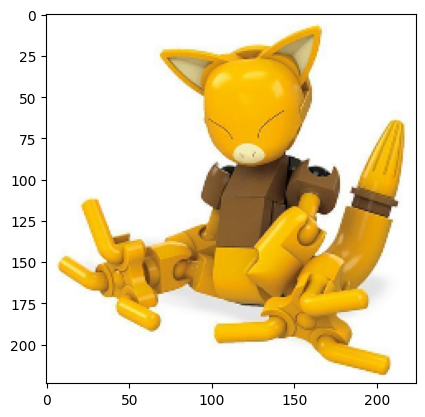

In [121]:
import cv2

resnet = resnet34(pretrained=True)
param = list(resnet.parameters())[-2]
weight = param.detach().numpy()

class ExtractFeature(nn.Module):
    def __init__(self):
        super(ExtractFeature, self).__init__()
        self.feature = nn.Sequential(
            *list(resnet.children())[0:-2])
        
    def forward(self, x):
        out = self.feature(x)
        return out


def getCam(weight, feature):
    
    # 가중치와 내적 계산
    map = weight.dot(feature)
    # 피쳐맵과 크기가 일치하도록 변경
    map = map.reshape(7, 7)
    # 정규화
    map = map - np.min(map)
    map = map / np.max(map)
    # 피쳐값 정수 변환
    map = np.uint8(255 * map)

    heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
    
    return cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # 색상 채널 변환

net = ExtractFeature()
raw = cv2.cvtColor(cv2.imread('/content/input/train/Abra/5c0ca320656b4f2fadea7aefeb80da53.jpg'), cv2.COLOR_BGR2RGB)
resizedImage = cv2.resize(raw, (224, 224))
inputImage = torch.tensor(resizedImage, dtype=torch.float)
inputImage = inputImage.permute(2, 1 ,0)
inputImage = inputImage.view(1, 3, 224, 224)
plt.imshow(resizedImage)

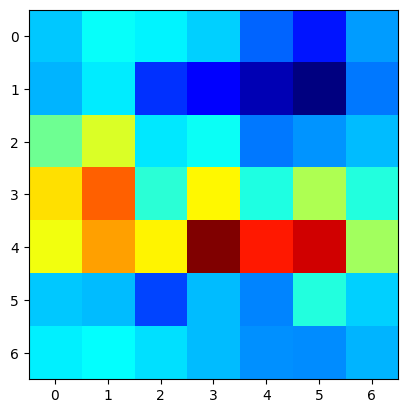

In [112]:
out = net(inputImage)
out = out.view(512, 7*7)
out = out.detach().numpy()
cam = getCam(weight[94], out)
plt.imshow(cam)

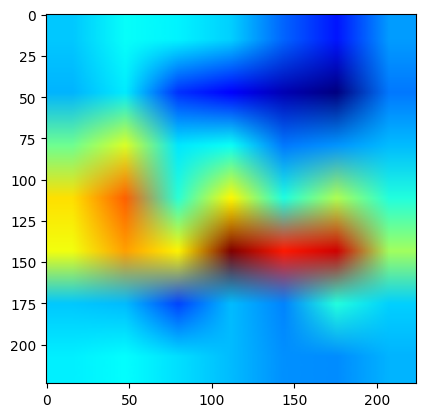

In [113]:
cam = cv2.resize(cam, (224,224))
plt.imshow(cam)

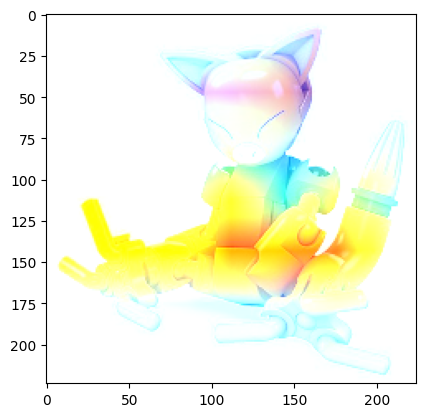

In [114]:
result = cv2.add(resizedImage, cam)
plt.imshow(result)

## 12 Visualization by GradCAM (3pts)

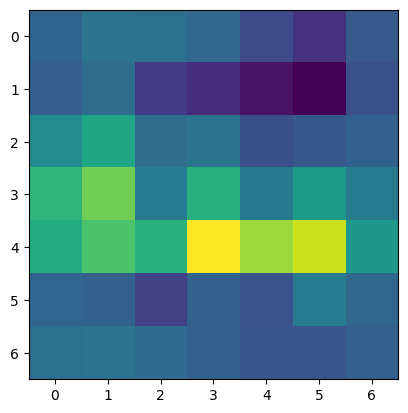

In [115]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

featuresFn = nn.Sequential(*list(resnet.children())[:-2])
classifierFn = nn.Sequential(*(list(resnet.children())[-2:-1] + [Flatten()] + list(resnet.children())[-1:]))

# 피쳐 추출
feats = featuresFn(inputImage)

out = classifierFn(feats)

c_score = out[0, 94]

# 선택 class에 대한 grad 계산
grads = torch.autograd.grad(c_score, feats)
# 가중치와 특성 내적 계산
w = grads[0][0].mean(-1).mean(-1)

map = torch.matmul(w, feats.view(512, 7*7))
map = map.view(7, 7).cpu().detach().numpy()
# map = np.maximum(map, 0)
plt.imshow(map)

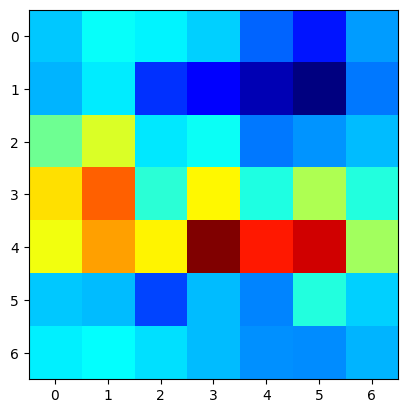

In [116]:
map = map - np.min(map)
map = map / np.max(map)
map = np.uint8(255 * map)
heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(heatmap)

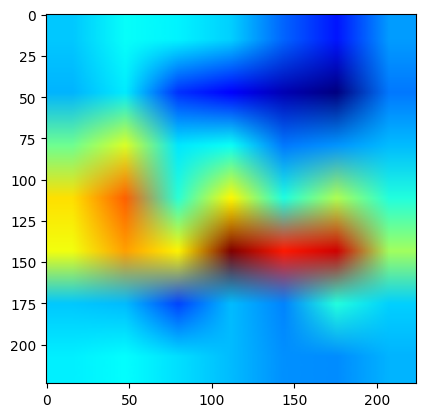

In [117]:
gradCam = cv2.resize(heatmap, (224,224))
plt.imshow(gradCam)

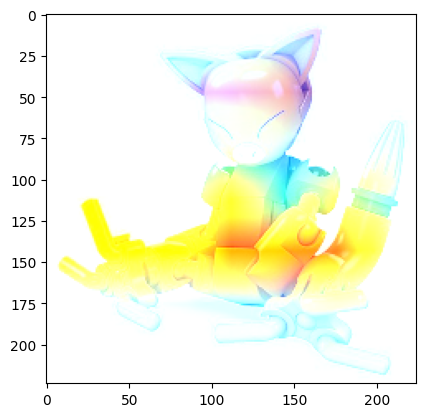

In [118]:
result = cv2.add(resizedImage, gradCam)
plt.imshow(result)